In [4]:
%matplotlib inline
import matplotlib
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt

def factorial(n):
    return 1 if n <= 1 else factorial(n - 1) * n

def gamma_fn(x):
    return factorial(x-1)
    
def beta_fn(x, y):
    return (gamma_fn(x) * gamma_fn(y)) / gamma_fn(x+y) 
    
def binomial_coefficient(n, k):
    return factorial(n) / (factorial(k) * factorial(n-k))

### Binomial Distribution

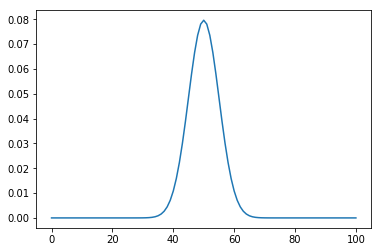

In [45]:
def plot_binomial_distribution(theta=1,n=20,color=''):
    def binomial_distribution(k):
        return binomial_coefficient(n,k) * theta ** k * (1-theta) ** (n-k)
    
    x = np.linspace(0, n, num=n+1)
    y = list(map(binomial_distribution, x))
    plt.plot(x, y, color)
    return plt
    
plot_binomial_distribution(theta=.5,n=100).show()

### Beta distribution

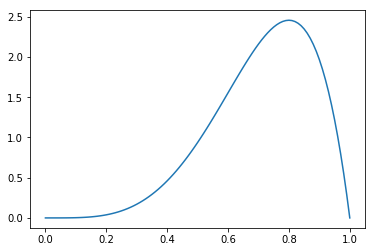

In [210]:
def plot_beta_distribution(alpha=1, beta=1, color=''):
    def beta_distribution(x):
        r = x ** (alpha-1) * (1-x) ** (beta-1)    
        return r / beta_fn(alpha, beta)

    x = np.linspace(0, 1, num=101)
    y = list(map(beta_distribution, x))
    plt.plot(x, y, color)
    return plt
    
plot_beta_distribution(alpha=5,beta=2).show()

### Maximum likelihood estimation for the binomial distribution

Successes: 102
Maximum likelihood theta: 0.51


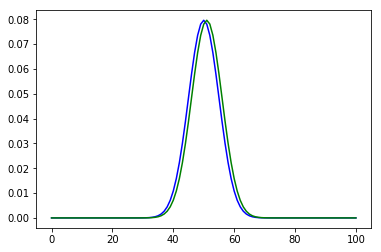

In [47]:
def maximum_likelihood(k, n):
    return k / n

theta = 0.5
n = 200
data = np.random.choice(2, n, p=[1-theta, theta])
k = np.sum(data)
print('Successes:', k)

estimated_theta = maximum_likelihood(k=k,n=n)
print('Maximum likelihood theta:', estimated_theta)

plot_binomial_distribution(theta=.5,n=100,color='b')
plot_binomial_distribution(theta=estimated_theta,n=100,color='g')

plt.show()

### Maximum a Posteriori Estimation for the Binomial Distribution

Prior successes: 10
Prior fails: 10
Posterior successes: 4
Posterior fails: 6
Maximum Likelihood theta: 0.4
Maximum a Posteriori theta: 0.464285714286


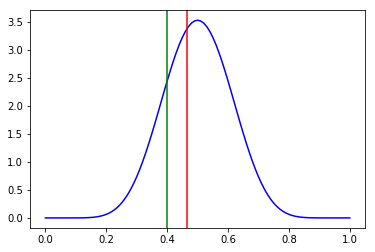

In [48]:
def maximum_a_posteriori(k, n, alpha, beta):
    return (k + alpha - 1) / (n + alpha + beta - 2)

theta = 0.5
n = 30
data = np.random.choice(2, n, p=[1-theta, theta])

prior_data = data[:-10]
new_data = data[-10:]

successes = np.sum(prior_data)
fails = (n - 10) - successes
print('Prior successes:', successes)
print('Prior fails:', fails)

alpha = successes
beta = fails

# Maximum likelihood for last 10 points.
successes = np.sum(new_data)
fails = 10 - successes
print('Posterior successes:', successes)
print('Posterior fails:', fails)

k = successes
n = successes + fails
ml_theta = maximum_likelihood(k,n)
map_theta = maximum_a_posteriori(k,n,alpha,beta)
print('Maximum Likelihood theta:', ml_theta)
print('Maximum a Posteriori theta:', map_theta)

plot_beta_distribution(alpha=alpha,beta=beta,color='b')
plt.axvline(x=ml_theta, color='g')
plt.axvline(x=map_theta, color='r')

plt.show()

### Analytical Bayesian Inference for the Binomial Distribution

Prior successes: 4
Prior fails: 6
Posterior successes: 4
Posterior fails: 6
Maximum Likelihood theta: 0.4
Maximum a Posteriori theta: 0.388888888889
Expected posterior theta: 0.4


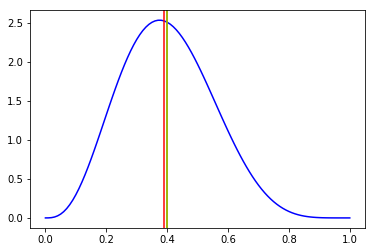

In [49]:
def expected_posterior(k, n, alpha, beta):
    return (k + alpha) / (n + alpha + beta)

theta = 0.5
n = 20
data = np.random.choice(2, n, p=[1-theta, theta])

prior_data = data[:-10]
new_data = data[-10:]

successes = np.sum(prior_data)
fails = (n - 10) - successes
print('Prior successes:', successes)
print('Prior fails:', fails)

alpha = successes
beta = fails

# Maximum likelihood for last 10 points.
successes = np.sum(new_data)
fails = 10 - successes
print('Posterior successes:', successes)
print('Posterior fails:', fails)

k = successes
n = successes + fails
ml_theta = maximum_likelihood(k,n)
map_theta = maximum_a_posteriori(k,n,alpha,beta)
expected_posterior_theta = expected_posterior(k,n,alpha,beta)
print('Maximum Likelihood theta:', ml_theta)
print('Maximum a Posteriori theta:', map_theta)
print('Expected posterior theta:', expected_posterior_theta)

plot_beta_distribution(alpha=alpha,beta=beta,color='b')
plt.axvline(x=ml_theta, color='g')
plt.axvline(x=map_theta, color='r')
plt.axvline(x=expected_posterior_theta, color='y')

plt.show()

### Metropolis Hastings for estimating posterior

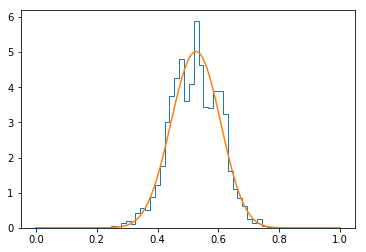

In [50]:
def binomial_distribution(n, k, theta):
        return binomial_coefficient(n,k) * theta ** k * (1-theta) ** (n-k)
    
def beta_distribution(x, alpha, beta):
    r = x ** (alpha-1) * (1-x) ** (beta-1)    
    return r / beta_fn(alpha, beta)

def target(lik, prior, n, h, theta, a, b):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, h, theta) * prior(theta, a, b)
    
n = 20
h = 11
a = 10
b = 10
theta = 0.1
sigma = 0.3

lik = binomial_distribution
prior = beta_distribution

niters = 10000
samples = np.zeros(niters+1)
samples[0] = theta

for i in range(niters):
    theta_p = theta + np.random.randn() * sigma
    
    rho = min(1, target(lik, prior, n, h, theta_p, a, b) / target(lik, prior, n, h, theta, a, b))
    
    u = np.random.uniform()
    if u < rho:
        theta = theta_p
    samples[i+1] = theta

burnin = len(samples)//2
plt.hist(samples[burnin:], 40, histtype='step', normed=True, linewidth=1, label='Prior')
plot_beta_distribution(alpha=h+a, beta=n-h+b)
plt.show()

### Gibbs Sampling

ML Theta 1: 0.5
MAP Theta 1: 0.5
Expected Posterior Theta 1: 0.5
Gibbs Theta 1: 0.500865263158
ML Theta 2: 0.15
MAP Theta 2: 0.18181818181818182
Expected Posterior Theta 2: 0.20833333333333334
Gibbs Theta 2: 0.209145263158


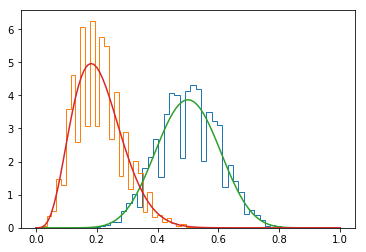

In [54]:
from functools import partial

a = 2
b = 2

n1 = 20
h1 = 10
n2 = 20
h2 = 3

def beta_distribution(alpha, beta, x):
    r = x ** (alpha-1) * (1-x) ** (beta-1)    
    return r / beta_fn(alpha, beta)

x_ = np.linspace(0, 1, num=101)
fn1 = partial(beta_distribution, a + h1, b + n1 - h1)
fn2 = partial(beta_distribution, a + h2, b + n2 - h2)
p1 = np.array(list(map(fn1, x_)))
p1 /= np.sum(p1)
p2 = np.array(list(map(fn2, x_)))
p2 /= np.sum(p2)
    
def random_beta_1():
    return np.random.choice(x_, p=p1)

def random_beta_2():
    return np.random.choice(x_, p=p2)

theta = [0.5, 2]
niters = 10000
burnin = 500

thetas = np.zeros((niters - burnin, 2))
for i in range(niters):
    theta1 = random_beta_1()
    theta2 = random_beta_2()
  
    if i >= burnin:
        thetas[i-burnin] = np.array([theta1, theta2])

plt.hist(thetas[:,0], 40, histtype='step', normed=True, linewidth=1)
plt.hist(thetas[:,1], 40, histtype='step', normed=True, linewidth=1)
plot_beta_distribution(alpha=a + h1, beta=b + n1 - h1)
plot_beta_distribution(alpha=a + h2, beta=b + n2 - h2)

print('ML Theta 1:', maximum_likelihood(h1,n1))
print('MAP Theta 1:', maximum_a_posteriori(h1,n1,a,b))
print('Expected Posterior Theta 1:', expected_posterior(h1,n1,a,b))
print('Gibbs Theta 1:', np.mean(thetas[:,0]))
print('Gibbs Theta 1:', np.mean(thetas[:,0]))
print()
print('MAP Theta 2:', maximum_a_posteriori(h2,n2,a,b))
print('Expected Posterior Theta 2:', expected_posterior(h2,n2,a,b))
print('Gibbs Theta 2:', np.mean(thetas[:,1]))

### Multinomial Distribution

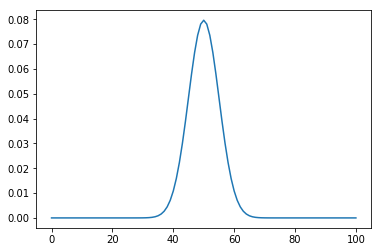

In [50]:
def plot_multinomial_distribution(thetas=[0.5, 0.5],n=10, color=''):
    k = len(thetas)
    def multinomial_distribution(x):
        r = factorial(n) / np.product(list(map(factorial, x)))
        return r * np.product(np.power(thetas, x))

    x = np.linspace(0, n, num=n+1)
    x_ = n - x
    x_ = np.stack([x, x_], axis=1)
    
    y = list(map(multinomial_distribution, x_))
    plt.plot(x, y, color)
    return plt

thetas = [0.5, 0.5]
n = 100
plot_multinomial_distribution(thetas=thetas,n=n).show()

### Expectation Maximization

Probabilities: [0.6625, 0.0875, 0.0875, 0.1625]
Counts: [6659  870  866 1605]
Theta at step 0: 0.500000
Theta at step 1: 0.628488
Theta at step 2: 0.648099
Theta at step 3: 0.650756
Theta at step 4: 0.651109
Theta at step 5: 0.651156
Theta at step 6: 0.651163
Theta at step 7: 0.651164
Theta at step 8: 0.651164
Theta at step 9: 0.651164
Actual theta: 0.65
ML theta: 0.653434343434 0.6500000000000001
EM theta: 0.651163641267


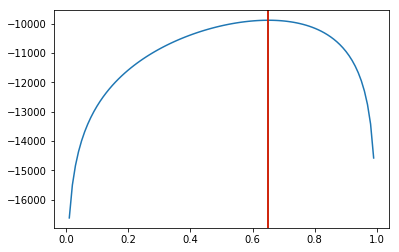

In [192]:
theta = 0.65
n = 10000
p = [0.5 + 0.25 * theta, 0.25 * (1 - theta), 0.25 * (1 - theta), 0.25 * theta]
print('Probabilities:', p)

choices = np.random.choice(4, n, p=p)
y = np.bincount(choices)
print('Counts:', y)

def likelihood(theta):
    p_ = [0.5 + 0.25 * theta, 0.25 * (1 - theta), 0.25 * (1 - theta), 0.25 * theta]
    return np.prod([np.power(p_[i], y[i]) for i in range(len(p_))])

def log_likelihood(theta):
    p_ = [0.5 + 0.25 * theta, 0.25 * (1 - theta), 0.25 * (1 - theta), 0.25 * theta]
    return np.sum([y[i] * np.log(p_[i]) for i in range(4)])

def max_likelihood(theta=0.5, delta=0.001):
    for i in range(2000):
        l1 = log_likelihood(theta)
        l2 = log_likelihood(theta+delta)
        if l2 < l1:
            theta = theta-delta
        else:
            theta = theta+delta
    return theta

def expectation_maximization():
    theta_m = 0.5 
    for i in range(10):
        print('Theta at step %d: %f' % (i, theta_m))
        num = (theta_m / (2.0 + theta_m)) * y[0] + y[3]
        den = num + y[1] + y[2]
        theta_m = num / den
    return theta_m
 
x = np.linspace(0.01, 0.99, num=100)                 
y_ = list(map(log_likelihood, x))
ml_theta = max_likelihood()
em_theta = expectation_maximization()
print('Actual theta:', theta)
print('ML theta:', x[np.argmax(y_)], ml_theta)
print('EM theta:', em_theta)

plt.plot(x, y_)
plt.axvline(x=ml_theta, color='g')
plt.axvline(x=em_theta, color='r')